## Import library

In [343]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.optimizers import Adam

## Données historiques

In [344]:
window_size = 12    # Utilise les 12 dernières heures pour prédire l'heure suivante
horizon = 200       # Prendre 200 heures pour le test

In [345]:
# Fonction pour prétraiter les données historiques
def preprocess_true_data(df):
    reference_date = pd.to_datetime("2016-12-31 00:00:00+00:00")
    new_df = df.copy()
    new_df['dayofweek'] = new_df['date'].dt.dayofweek
    new_df['hourofday'] = new_df['date'].dt.hour
    new_df['dayofyear'] = new_df['date'].dt.dayofyear
    new_df["dayofseries"] = (new_df["date"] - reference_date).dt.days
    new_df["hoursofseries"] = new_df["dayofseries"]*24 + new_df["hourofday"]
    return new_df

In [346]:
df_price = pd.read_parquet("../data/CYTECH/donnees historiques/prix/hourly_day_ahead_prices_2017_2020.parquet").reset_index()
df_price_preprocessed = preprocess_true_data(df_price)
df_price_preprocessed.to_csv("test.csv", sep=";")
df_price_preprocessed.head(40)

,date,price,dayofweek,hourofday,dayofyear,dayofseries,hoursofseries
0,2016-12-31 23:00:00+00:00,58.82,5,23,366,0,23
1,2017-01-01 00:00:00+00:00,58.23,6,0,1,1,24
2,2017-01-01 01:00:00+00:00,51.95,6,1,1,1,25
3,2017-01-01 02:00:00+00:00,47.27,6,2,1,1,26
4,2017-01-01 03:00:00+00:00,45.49,6,3,1,1,27
5,2017-01-01 04:00:00+00:00,44.50,6,4,1,1,28
6,2017-01-01 05:00:00+00:00,44.50,6,5,1,1,29
7,2017-01-01 06:00:00+00:00,44.72,6,6,1,1,30
8,2017-01-01 07:00:00+00:00,44.22,6,7,1,1,31
9,2017-01-01 08:00:00+00:00,42.06,6,8,1,1,32


In [347]:
def split_data(df, horizon):
    train_df = df[:-horizon]
    test_df = df[-horizon:]
    return train_df, test_df

## Préparer les données d'entrainement

In [348]:
def create_input_output(df, window_size):
    X = []
    y = []
    
    # X = prix des "window_size" dernières heures, jour de la semaine, heure, jour de l'année
    for i in range(window_size, len(df)):
        
        # Retrieve the "window_size" last price
        x_data = df.iloc[i-window_size:i][['price']].values.flatten()
    
        # Data context of the hour we will predict
        x_data = np.concatenate([x_data, [df.iloc[i]['dayofweek'], df.iloc[i]['hourofday'], df.iloc[i]['dayofyear']]])
        
        # y : prix de l'électricité à l'heure suivante
        y.append(df.iloc[i]['price'])
        X.append(x_data)
    
    return np.array(X), np.array(y)

In [349]:
train_data, test_data = split_data(df_price_preprocessed, horizon)

X_train, y_train = create_input_output(train_data, window_size)

print(X_train)
print(y_train)

[[ 58.82  58.23  51.95 ...   6.    11.     1.  ]
 [ 58.23  51.95  47.27 ...   6.    12.     1.  ]
 [ 51.95  47.27  45.49 ...   6.    13.     1.  ]
 ...
 [ 34.2   33.5   31.13 ...   2.    12.   358.  ]
 [ 33.5   31.13  31.91 ...   2.    13.   358.  ]
 [ 31.13  31.91  32.11 ...   2.    14.   358.  ]]
[49.57 48.69 46.91 ... 50.95 49.12 38.27]


## Récupération des données de test

In [366]:
temp = test_data['price'][:window_size].to_numpy()

hour = test_data.iloc[window_size]['hourofday']
dayofweek = test_data.iloc[window_size]['dayofweek']
dayofyear = test_data.iloc[window_size]['dayofyear']

X_test_first = np.concatenate([temp, [dayofweek, hour, dayofyear]])
y_test = test_data[window_size:]

## Conv1D

In [351]:
# Fonction pour créer le modèle Conv1D
def create_conv1d_model(input_shape):
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    # model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=input_shape))
    # model.add(MaxPooling1D(pool_size=2))  # Réduit la dimension tout en gardant l'essentiel
    # model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))  # Prédiction du prix à l'heure suivante
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model

In [352]:
# Créer le modèle
input_shape = (X_train.shape[1], 1)
model = create_conv1d_model(input_shape)

# Afficher le résumé du modèle
model.summary()

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_28 (Conv1D)              │ (None, 13, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_58 (Dense)                │ (None, 64)             │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_59 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,633 (209.50 KB)

 Trainable params: 53,633 (209.50 KB)

 Non-trainable params: 0 (0.00 B)

In [353]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_reshaped, y_train, test_size=0.2, random_state=42)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entraîner le modèle avec les données de validation
history = model.fit(
    X_train_split, y_train_split,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_split, y_val_split),  # Spécifier les données de validation
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 118.8402 - mae: 6.1282 - val_loss: 20.3718 - val_mae: 2.8999
Epoch 2/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 24.0614 - mae: 3.1702 - val_loss: 22.7559 - val_mae: 3.2700
Epoch 3/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 20.9513 - mae: 2.9830 - val_loss: 21.7723 - val_mae: 3.2289
Epoch 4/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 21.0438 - mae: 2.9444 - val_loss: 18.7391 - val_mae: 2.8755
Epoch 5/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 20.7693 - mae: 2.9807 - val_loss: 18.2724 - val_mae: 2.8061
Epoch 6/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 20.6747 - mae: 2.9158 - val_loss: 17.7920 - val_mae: 2.7716
Epoch 7/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 19.4494 - mae: 2.8345 - val_loss: 17.6237 - val_mae: 2.7217
Epoch 8/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 19.7240 - mae: 2.8355 - val_loss: 27.2677 - val_mae: 3.7879
Epoch 9/50
872/872 ━━━━━━━━━━━━━━━━━━━━

## GRU

In [392]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_gru_model(input_shape):
    model = Sequential()

    model.add(GRU(64, return_sequences=True, input_shape=input_shape, activation='relu'))
    model.add(Dropout(0.2))  # Régularisation
    
    model.add(GRU(32, return_sequences=False, activation='relu'))
    model.add(Dropout(0.2)) # Régularisation
    
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1))
    
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
    return model


In [393]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

X_train_gru_reshape = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train_gru_split, X_val_gru_split, y_train_gru_split, y_val_gru_split = train_test_split(X_train_gru_reshape, y_train, test_size=0.2, random_state=42)


input_shape = (X_train.shape[1], 1)
gru_model = create_gru_model(input_shape)

gru_model.summary()

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Entraîner le modèle avec les données de validation
history = gru_model.fit(
    X_train_gru_split, y_train_gru_split,
    epochs=50,
    batch_size=32,
    validation_data=(X_val_gru_split, y_val_gru_split),  # Spécifier les données de validation
    verbose=1,
    callbacks=[early_stopping]
)

Model: "sequential_36"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_22 (GRU)                    │ (None, 15, 64)         │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 15, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_23 (GRU)                    │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_72 (Dense)                │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_73 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,449 (95.50 KB)

 Trainable params: 24,449 (95.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 13s 11ms/step - loss: 233.5660 - mae: 9.5955 - val_loss: 122.8398 - val_mae: 9.6625
Epoch 2/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 34.4122 - mae: 4.0179 - val_loss: 119.0037 - val_mae: 9.1312
Epoch 3/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 33.0979 - mae: 3.8176 - val_loss: 128.0160 - val_mae: 9.9629
Epoch 4/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 27.4128 - mae: 3.5295 - val_loss: 115.7251 - val_mae: 9.3698
Epoch 5/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 24.6682 - mae: 3.3733 - val_loss: 148.9935 - val_mae: 10.6920
Epoch 6/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 24.7079 - mae: 3.3486 - val_loss: 137.0719 - val_mae: 10.3652
Epoch 7/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 25.7781 - mae: 3.3883 - val_loss: 195.0401 - val_mae: 12.5110
Epoch 8/50
872/872 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 21.7518 - mae: 3.1963 - val_loss: 213.6214 - val_mae: 13.1352
Epoch 9/50
872/87

## Prediction

In [394]:
def autoregressive_prediction(model, X_test_first, step):

    predictions = []
    
    for _ in range(step):

        print(X_test_first)
        print(X_test_first.reshape(1, -1))

        X_test_reshape = X_test_first.reshape(1, -1)  # Reshape pour le modèle
        next_price = model.predict(X_test_reshape)[0][0]  # Prédiction de h+1
        predictions.append(next_price)

        print(next_price)

        hourofday = (X_test_first[-2] + 1) % 24 
        dayofweek = X_test_first[-3]
        dayofyear = X_test_first[-1]

        if hourofday == 0:
            dayofweek = (X_test_first[-3] + 1) % 7
            dayofyear = (X_test_first[-1] + 1) % 365 

        X_test_first = np.concatenate([X_test_first[1:window_size], [next_price, dayofweek, hourofday, dayofyear]])
    
    return predictions

In [395]:
step = 6          # Nombre d'heure que l'on veut prédire

# predictions = autoregressive_prediction(model, X_test_first, step)
predictions = autoregressive_prediction(gru_model, X_test_first, step)
print(predictions)

[3.900e+01 5.208e+01 5.113e+01 4.482e+01 4.025e+01 3.315e+01 3.039e+01
 2.804e+01 7.590e+00 1.091e+01 5.930e+00 4.000e-02 3.000e+00 3.000e+00
 3.590e+02]
[[3.900e+01 5.208e+01 5.113e+01 4.482e+01 4.025e+01 3.315e+01 3.039e+01
  2.804e+01 7.590e+00 1.091e+01 5.930e+00 4.000e-02 3.000e+00 3.000e+00
  3.590e+02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
2.3377757
[5.20800000e+01 5.11300000e+01 4.48200000e+01 4.02500000e+01
 3.31500000e+01 3.03900000e+01 2.80400000e+01 7.59000000e+00
 1.09100000e+01 5.93000000e+00 4.00000000e-02 2.33777571e+00
 3.00000000e+00 4.00000000e+00 3.59000000e+02]
[[5.20800000e+01 5.11300000e+01 4.48200000e+01 4.02500000e+01
  3.31500000e+01 3.03900000e+01 2.80400000e+01 7.59000000e+00
  1.09100000e+01 5.93000000e+00 4.00000000e-02 2.33777571e+00
  3.00000000e+00 4.00000000e+00 3.59000000e+02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
0.8113245
[5.11300000e+01 4.48200000e+01 4.02500000e+01 3.31500000e+01
 3.03900000e+01 2.80400000e+01 7.59000000e+00 1.09100000e+01
 5.9

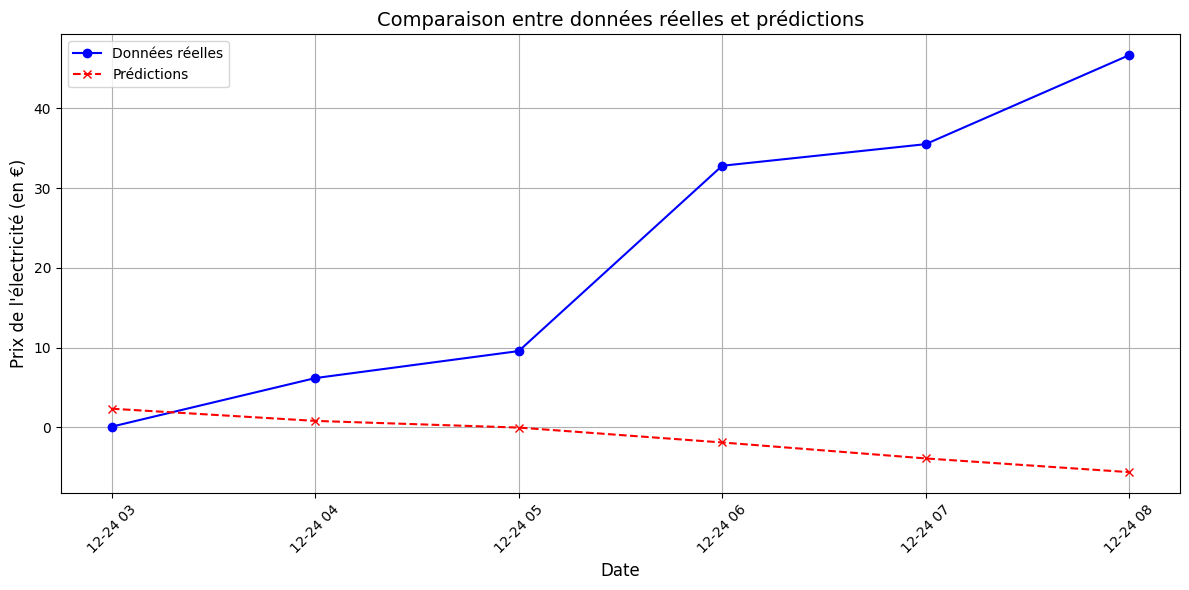

In [396]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_predictions(y_test_df, predicted_values, step=None):
    """
    Trace les valeurs réelles et prédites avec des dates lisibles sur l'axe des abscisses.
    """
    # Limiter le nombre de points à afficher si 'step' est spécifié
    if step:
        y_test_df = y_test_df[:step]
        predicted_values = predicted_values[:step]
    
    # Extraire les dates et les prix réels
    dates = pd.to_datetime(y_test_df['date'])
    true_values = y_test_df['price'].to_numpy()
    
    # Créer le tracé
    plt.figure(figsize=(12, 6))
    plt.plot(dates, true_values, label='Données réelles', color='blue', linestyle='-', marker='o')
    plt.plot(dates, predicted_values, label='Prédictions', color='red', linestyle='--', marker='x')
    
    plt.title("Comparaison entre données réelles et prédictions", fontsize=14)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Prix de l'électricité (en €)", fontsize=12)
    
    # Rotation des dates pour une meilleure lisibilité
    plt.xticks(rotation=45, fontsize=10)
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


plot_predictions(y_test, predictions, step)


## Évaluer le modèle

In [380]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test['price'][:step].to_numpy(), predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test['price'][:step].to_numpy(), predictions)

# Affichage des résultats
print(f"MSE : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE : {mae:.4f}")


MSE : 30.8811
RMSE : 5.5571
MAE : 4.3523


## Données synthétiques

In [68]:
# Fonction pour prétraiter les données générées synthétiquement
def preprocess_synthetic_data(df):
    new_df = df.copy()
    
    new_df['dayofseries'] = (new_df.index // 24)
    
    # Ajouter la colonne dayofyear
    new_df['dayofyear'] = (new_df['dayofseries'] % 365) + 1

    # Ajouter la colonne hoursofseries
    new_df["hoursofseries"] = new_df["dayofseries"] * 24 + new_df["hourofday"]
    
    return new_df


In [69]:
df_price_generated_11618 = pd.read_parquet("../data/CYTECH/scenarios synthetiques/prix/11618.parquet")
df_price_generated_11618_2 = preprocess_synthetic_data(df_price_generated_11618)

df_price_generated_11618_2.to_csv("test7.csv", sep=";")

In [70]:
def create_input_output(df, window_size):
    X = []
    y = []
    
    # X : les n dernières heures (prix), jour de la semaine, heure, jour de l'année, jour de la serie
    for i in range(window_size, len(df)):
        
        # Retrieve the n last price
        x_data = df.iloc[i-window_size:i][['price']].values.flatten()
    
        # Data context of the hour predicted
        # x_data = np.concatenate([x_data, [df.iloc[i]['dayofweek'], df.iloc[i]['hourofday'], df.iloc[i]['dayofyear'], df.iloc[i]['dayofseries']]])
        x_data = np.concatenate([x_data, [df.iloc[i]['dayofweek'], df.iloc[i]['hourofday'], df.iloc[i]['dayofyear']]])
        
        # y : prix de l'électricité à l'heure suivante
        y.append(df.iloc[i]['price'])
        
        X.append(x_data)
    
    return X, y

In [71]:
# Fonction pour traiter plusieurs fichiers
def process_multiple_files(file_list, window_size):
    all_X = []
    all_y = []
    
    for file in tqdm(file_list):
        # Charger le fichier
        df = pd.read_parquet(file)
        
        # Prétraitement
        df = preprocess_synthetic_data(df)
        
        # Création des entrées et sorties
        X, y = create_input_output(df, window_size)
        
        # Ajouter les résultats aux listes globales
        all_X.append(X)
        all_y.append(y)
        
    return np.array(all_X), np.array(all_y)

In [72]:
# Fonction pour lister tous les fichiers CSV dans un dossier
def get_csv_files_from_directory(directory):
    return [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.parquet')]

# Exemple : spécifier le dossier
directory = r"..\data\CYTECH\scenarios synthetiques\prix"
file_list = get_csv_files_from_directory(directory)

all_X, all_y = process_multiple_files(file_list, window_size)

100%|██████████| 154/154 [46:02<00:00, 17.94s/it]


In [73]:
all_X = np.concatenate(all_X, axis=0)
all_y = np.concatenate(all_y, axis=0)

In [74]:
print(all_X)
print(all_y)

[[ 31.66  31.06  27.81 ...   0.    12.     1.  ]
 [ 31.06  27.81  27.54 ...   0.    13.     1.  ]
 [ 27.81  27.54  25.04 ...   0.    14.     1.  ]
 ...
 [ 29.04  30.48  26.47 ...   6.    21.   361.  ]
 [ 30.48  26.47  21.58 ...   6.    22.   361.  ]
 [ 26.47  21.58  13.89 ...   6.    23.   361.  ]]
[23.79 26.21 27.56 ... 31.57 32.57 30.74]


In [75]:
# Créer le modèle
input_shape = (all_X.shape[1], 1)
model2 = create_conv1d_model(input_shape)

# Afficher le résumé du modèle
model2.summary()

c:\Users\Maxime\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_5 (Conv1D)               │ (None, 13, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 832)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 64)             │        53,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,633 (209.50 KB)

 Trainable params: 53,633 (209.50 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
X_train_reshaped = all_X.reshape(all_X.shape[0], all_X.shape[1], 1)

# Entraîner le modèle
history = model2.fit(
    X_train_reshaped, all_y,
    epochs=10,  # Ajustez le nombre d'époques selon vos besoins
    batch_size=32,
    verbose=1
)

Epoch 1/10
168111/168111 ━━━━━━━━━━━━━━━━━━━━ 417s 2ms/step - loss: 18.5543 - mae: 2.8104
Epoch 2/10
168111/168111 ━━━━━━━━━━━━━━━━━━━━ 411s 2ms/step - loss: 13.6438 - mae: 2.4892
Epoch 3/10
168111/168111 ━━━━━━━━━━━━━━━━━━━━ 388s 2ms/step - loss: 12.6605 - mae: 2.4203
Epoch 4/10
168111/168111 ━━━━━━━━━━━━━━━━━━━━ 391s 2ms/step - loss: 11.9869 - mae: 2.3709
Epoch 5/10
168111/168111 ━━━━━━━━━━━━━━━━━━━━ 406s 2ms/step - loss: 11.4712 - mae: 2.3280
Epoch 6/10
168111/168111 ━━━━━━━━━━━━━━━━━━━━ 403s 2ms/step - loss: 11.0916 - mae: 2.3015
Epoch 7/10
168111/168111 ━━━━━━━━━━━━━━━━━━━━ 414s 2ms/step - loss: 10.8860 - mae: 2.2832
Epoch 8/10
168111/168111 ━━━━━━━━━━━━━━━━━━━━ 482s 3ms/step - loss: 10.6863 - mae: 2.2663
Epoch 9/10
168111/168111 ━━━━━━━━━━━━━━━━━━━━ 743s 4ms/step - loss: 10.4674 - mae: 2.2538
Epoch 10/10
168111/168111 ━━━━━━━━━━━━━━━━━━━━ 805s 5ms/step - loss: 10.3141 - mae: 2.2413


In [77]:
import numpy as np

def autoregressive_prediction(model2, X_test_first, step):

    predictions = []
    
    for _ in range(step):

        print(X_test_first)
        print(X_test_first.reshape(1, -1))

        X_test_reshape = X_test_first.reshape(1, -1)  # Reshape pour le modèle
        next_price = model2.predict(X_test_reshape)[0][0]  # Prédiction de h+1
        predictions.append(next_price)

        print(next_price)

        hourofday = (X_test_first[-2] + 1) % 24 
        dayofweek = X_test_first[-3]
        dayofyear = X_test_first[-1]

        if hourofday == 0:
            dayofweek = (X_test_first[-3] + 1) % 7
            dayofyear = (X_test_first[-1] + 1) % 365 

        # dayofweek = (X_test_first[-4] + 1) % 7  
        # hourofday = (X_test_first[-3] + 1) % 24 
        # dayofyear = (X_test_first[-2] + 1) % 365 
        # dayofseries = X_test_first[-1] + 1

        # X_test_first = np.concatenate([X_test_first[1:window_size], [next_price, dayofweek, hourofday, dayofyear, dayofseries]])
        X_test_first = np.concatenate([X_test_first[1:window_size], [next_price, dayofweek, hourofday, dayofyear]])
    
    return predictions

In [341]:
step = 72

predictions = autoregressive_prediction(model2, X_test_first, step)
print(predictions)

[3.900e+01 5.208e+01 5.113e+01 4.482e+01 4.025e+01 3.315e+01 3.039e+01
 2.804e+01 7.590e+00 1.091e+01 5.930e+00 4.000e-02 3.000e+00 3.000e+00
 3.590e+02]
[[3.900e+01 5.208e+01 5.113e+01 4.482e+01 4.025e+01 3.315e+01 3.039e+01
  2.804e+01 7.590e+00 1.091e+01 5.930e+00 4.000e-02 3.000e+00 3.000e+00
  3.590e+02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
3.0615616
[5.20800000e+01 5.11300000e+01 4.48200000e+01 4.02500000e+01
 3.31500000e+01 3.03900000e+01 2.80400000e+01 7.59000000e+00
 1.09100000e+01 5.93000000e+00 4.00000000e-02 3.06156158e+00
 3.00000000e+00 4.00000000e+00 3.59000000e+02]
[[5.20800000e+01 5.11300000e+01 4.48200000e+01 4.02500000e+01
  3.31500000e+01 3.03900000e+01 2.80400000e+01 7.59000000e+00
  1.09100000e+01 5.93000000e+00 4.00000000e-02 3.06156158e+00
  3.00000000e+00 4.00000000e+00 3.59000000e+02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
15.96162
[5.11300000e+01 4.48200000e+01 4.02500000e+01 3.31500000e+01
 3.03900000e+01 2.80400000e+01 7.59000000e+00 1.09100000e+01
 5.930

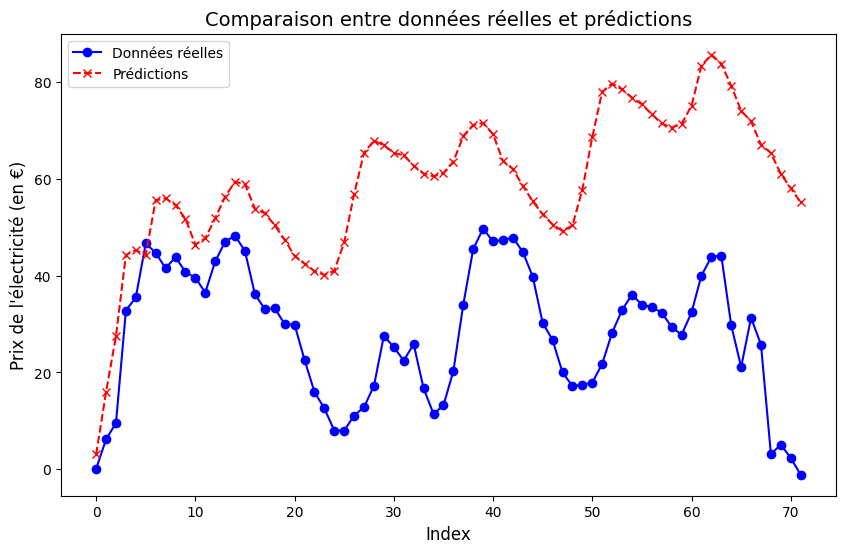

In [342]:
import matplotlib.pyplot as plt

def plot_predictions(true_values, predicted_values):
    plt.figure(figsize=(10, 6))
    

    plt.plot(true_values, label='Données réelles', color='blue', linestyle='-', marker='o')
    plt.plot(predicted_values, label='Prédictions', color='red', linestyle='--', marker='x')
    
    plt.title("Comparaison entre données réelles et prédictions", fontsize=14)
    plt.xlabel("Index", fontsize=12)
    plt.ylabel("Prix de l'électricité (en €)", fontsize=12)
    
    plt.legend(loc='upper left')
    plt.show()

# Exemple d'utilisation avec les prédictions et y_test[0]
plot_predictions(y_test[:step], predictions)


In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mse = mean_squared_error(y_test[:step], predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test[:step], predictions)

# Affichage des résultats
print(f"MSE : {mse:.4f}")
print(f"RMSE : {rmse:.4f}")
print(f"MAE : {mae:.4f}")


MSE : 1166.9408
RMSE : 34.1605
MAE : 30.2791


# ------------------------------------  Inutile  ----------------------------------------

In [441]:
df_price_generated_11113 = pd.read_parquet("../data/CYTECH/scenarios synthetiques/prix/99621.parquet")
df_price_generated_11618 = pd.read_parquet("../data/CYTECH/scenarios synthetiques/prix/11618.parquet")
df_price_generated_11113.to_csv("test2.csv", sep=";")
df_price_generated_11618.to_csv("test3.csv", sep=";")
print(len(df_price_generated_11113))

print(df_price_generated_11113.head(40))

34944
    price  dayofweek  hourofday
0   31.66          0          0
1   31.06          0          1
2   27.81          0          2
3   27.54          0          3
4   25.04          0          4
5   23.57          0          5
6   27.09          0          6
7   29.01          0          7
8   26.22          0          8
9   26.37          0          9
10  30.50          0         10
11  26.24          0         11
12  23.79          0         12
13  26.21          0         13
14  27.56          0         14
15  32.00          0         15
16  44.97          0         16
17  46.07          0         17
18  46.07          0         18
19  44.52          0         19
20  59.20          0         20
21  53.69          0         21
22  38.95          0         22
23  29.36          0         23
24  20.98          1          0
25  22.16          1          1
26  18.80          1          2
27  18.80          1          3
28  26.21          1          4
29  41.08          1          5
30

In [442]:
df_price_generated_11113 = pd.read_parquet("../data/CYTECH/scenarios synthetiques/prix/11113.parquet")
df_price_generated_11113_preprocessed = preprocess_synthetic_data(df_price_generated_11113)

df_price_generated_11113_preprocessed.head(30)
df_price_generated_11113_preprocessed.to_csv("test5.csv", sep=";")

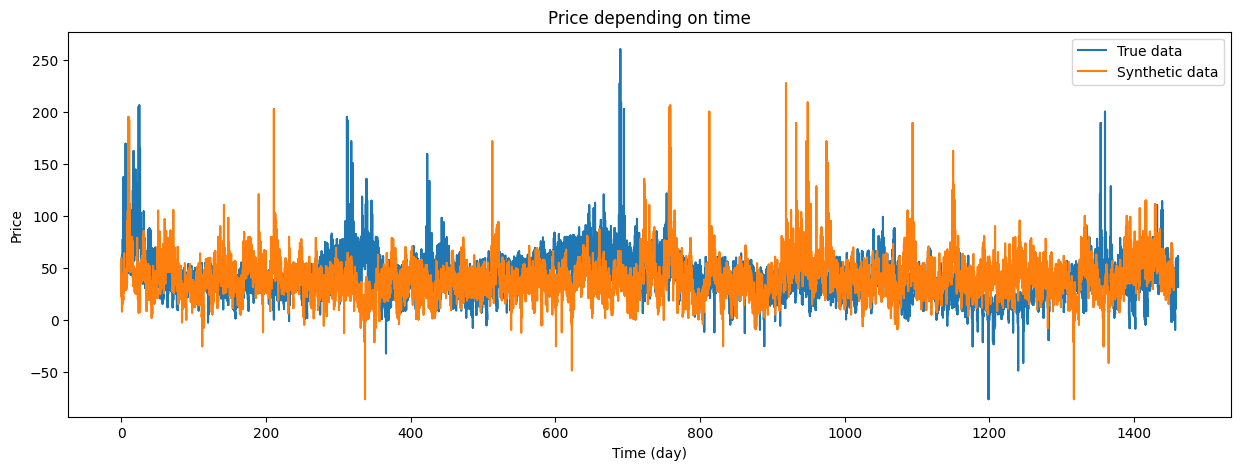

In [359]:
plt.figure(figsize=(15,5))
plt.plot(df_price_preprocessed["dayofseries"], df_price_preprocessed["price"], label="True data")
plt.plot(df_price_generated_11113_preprocessed["dayofseries"], df_price_generated_11113_preprocessed["price"], label="Synthetic data")
plt.title('Price depending on time')
plt.xlabel('Time (day)')
plt.ylabel('Price')
plt.legend()

plt.show()